# Step 1: Import Libraries and Load the Dataset

In [1]:
# Imports

#pathlib: modern, clean way to handle file and folder paths
from pathlib import Path

#shutil: used to copy files from raw folders to the train and test folders
import shutil

import random

# nump useful for numerical operations
import numpy as np

import pandas as pd

#matplotlib.pyplot: uswed for visualizations
import matplotlib.pyplot as plt


import seaborn as sns

from PIL import Image

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

from sklearn.metrics import precision_recall_curve, average_precision_score

#tensorflow and keras for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import load_model




# Step 2: Data setup
- Reduce the dataset 25,000 > 5000 train (2500 each), 2000 test (1000 each)
- Initialize path for train and test
- Split dataset into train and test

In [2]:
# Here we first must define the original datasets paths
# then educe them to 5,000 images for train and 2,000 for test which will be appropriate for the scale of the workshop

raw_train_dir = Path("data/raw/train/train")
# raw_test_dir  = Path("data/raw/test/test")

#Paths for processsed/reduced dataset
train_dir = Path("data/train")
test_dir = Path("data/test")


#move iamges into subfolders for cat and dog

for folder in [train_dir /"cats", train_dir / "dogs",
               test_dir / "cats", test_dir / "dogs",]:
    folder.mkdir(parents=True, exist_ok=True)


#Randomly takes 2,5000 cats and dog images from the data set to for the reduced training dataset

def copy_random_n_images_by_prefix(src_folder, prefix, dest_folder, n):

    all_files = list(src_folder.glob(f"{prefix}*.jpg")) #list all images
    random.shuffle(all_files) #randomly  pick n
    selected = all_files[:n]
    for f in selected:
        shutil.copy(f, dest_folder /f.name)

#Copy the random 2,5000 per class for training (cats and dogs)
copy_random_n_images_by_prefix(src_folder=raw_train_dir, prefix="cat", dest_folder=train_dir / "cats", n=2500)
copy_random_n_images_by_prefix(src_folder=raw_train_dir, prefix="dog", dest_folder=train_dir / "dogs", n=2500)

#Since the training is labeled byt the test is not we get the reaming cats and dogs from the train set and then shuffle and pick test
test_cats = list(raw_train_dir.glob("cat*.jpg"))
test_dogs = list(raw_train_dir.glob("dog*.jpg"))

#shuffle
random.shuffle(test_cats)
random.shuffle(test_dogs)

for f in test_cats [2500:3500]:
    shutil.copy(f, test_dir /"cats"/f.name)

for f in test_dogs [2500:3500]:
    shutil.copy(f, test_dir /"dogs"/f.name)

#print result

print("REduced dataset created sucessfully")


REduced dataset created sucessfully


# Step 3: EDA
- Count amount of images per class
- Visualize distribution using barplot
- Display sample images from each class

Training set: {'cats': 2500, 'dogs': 2500}
Test set: {'cats': 1000, 'dogs': 1000}


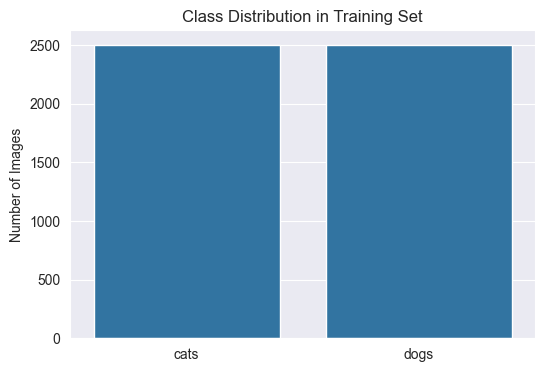

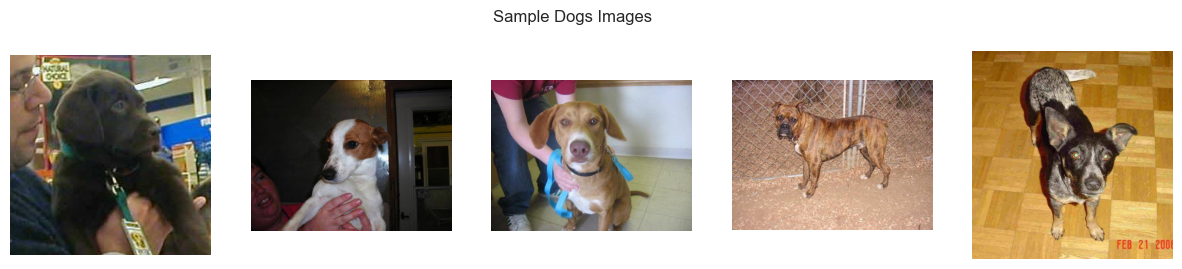

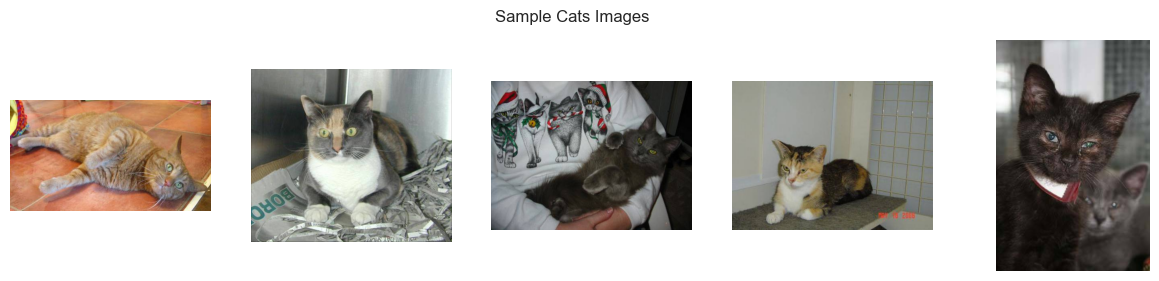

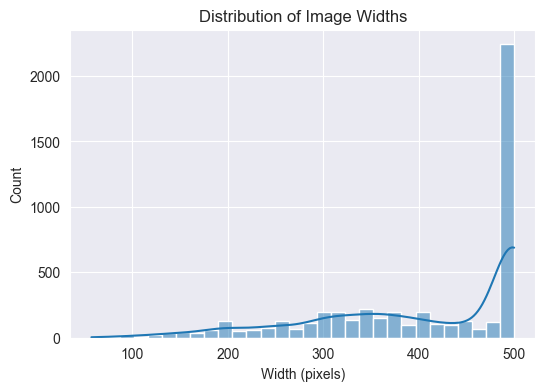

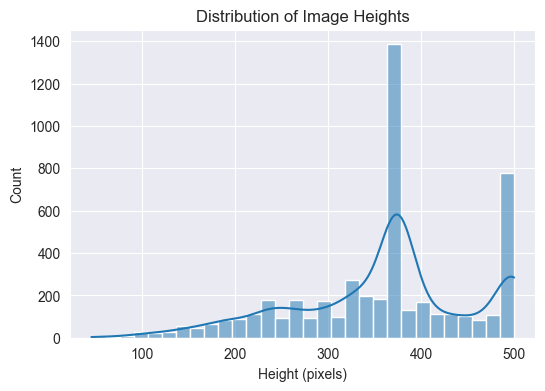

Image Width Stats
Mean: 404.54
Median: 448.00
Max: 500.00
Min: 57.00

Image Heights Stats
Mean: 359.31
Median: 374.00
Max: 500.00
Min: 46.00


In [3]:
# Count the amount of images are present per class

def count_images(directory):
    classes = ["cats", "dogs"]
    counts = {}
    for cls in classes:
        counts[cls] = len(list((directory / cls).glob("*.jpg")))
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Training set:", train_counts)
print("Test set:", test_counts)

# Visualize distribution of cats vs dogs

plt.figure(figsize=(6,4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.show()

#Show Sample Images from each class

def show_samples(directory, class_name, n=5):
    files = list((directory / class_name).glob("*.jpg"))
    samples = random.sample(files, n)

    plt.figure(figsize=(15,3))
    for i, img_path in enumerate(samples):
        img = Image.open(img_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Sample {class_name.capitalize()} Images")
    plt.show()

show_samples(train_dir, "dogs")
show_samples(test_dir, "cats")


#Analyze image sizes (width x height)
def get_image_sizes(directory):
    sizes = []
    for cls in ["cats", "dogs"]:
        for img_path in (directory / cls).glob("*.jpg"):
            img = Image.open(img_path)
            sizes.append(img.size)
    return np.array(sizes)
sizes = get_image_sizes(train_dir)
widths = sizes[:, 0]
heights = sizes[:, 1]


#Histogram of widths and heights
plt.figure(figsize=(6,4))
sns.histplot(widths, bins=30, kde=True)
plt.title("Distribution of Image Widths")
plt.xlabel("Width (pixels)")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(heights, bins=30, kde=True)
plt.title("Distribution of Image Heights")
plt.xlabel("Height (pixels)")
plt.show()


#Print staistics
print("Image Width Stats")
print(f"Mean: {np.mean(widths):.2f}")
print(f"Median: {np.median(widths):.2f}")
print(f"Max: {np.max(widths):.2f}")
print(f"Min: {np.min(widths):.2f}")

print("\nImage Heights Stats")
print(f"Mean: {np.mean(heights):.2f}")
print(f"Median: {np.median(heights):.2f}")
print(f"Max: {np.max(heights):.2f}")
print(f"Min: {np.min(heights):.2f}")

# Step 4: Define a Neural Network
- Set image dimensions
- Define model with conv2d, maxpooling, dense, dropout layers
- Compile Model
- Use callbacks to save best model
- Train model

In [4]:
# Image Dimensions

img_height = 150
img_width = 150
batch_size = 32

#Data generators for training and validation

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2 # this si 20% of training data used as validation
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="training",
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    subset="validation",
    shuffle=True

)

#Define the model

custom_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') #binary classification
])

#Compile model

custom_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# CAllback to save the best model

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/best_model.h5", save_best_only=True
)

# Train the model

history_custom = custom_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint_cb]

)


Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


C:\Users\jjbed\Downloads\PracticalLabCNN_3_JB-\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.5498 - loss: 0.7969

125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 221ms/step - accuracy: 0.5888 - loss: 0.6959 - val_accuracy: 0.6540 - val_loss: 0.6408
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6499 - loss: 0.6305

125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 219ms/step - accuracy: 0.6695 - loss: 0.6118 - val_accuracy: 0.6780 - val_loss: 0.6105
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.7535 - loss: 0.5195 - val_accuracy: 0.6860 - val_loss: 0.6118
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8134 - loss: 0.4280

125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.8117 - loss: 0.4259 - val_accuracy: 0.6970 - val_loss: 0.6031
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.8698 - loss: 0.3175 - val_accuracy: 0.6880 - val_loss: 0.6907
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.9175 - loss: 0.2206 - val_accuracy: 0.7100 - val_loss: 0.6949
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.9488 - loss: 0.1435 - val_accuracy: 0.7180 - val_loss: 0.8042
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.9685 - loss: 0.0952 - val_accuracy: 0.7120 - val_loss: 0.9810
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.9797 - loss: 0.0624 - val_accuracy: 0.7020 - val_loss: 1.0422
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 218ms/step - accuracy: 0.9850 - loss: 0.0454 - val_accuracy: 0.7160 - val_loss: 1.2440


## Traning Vs Validation Plot for Model

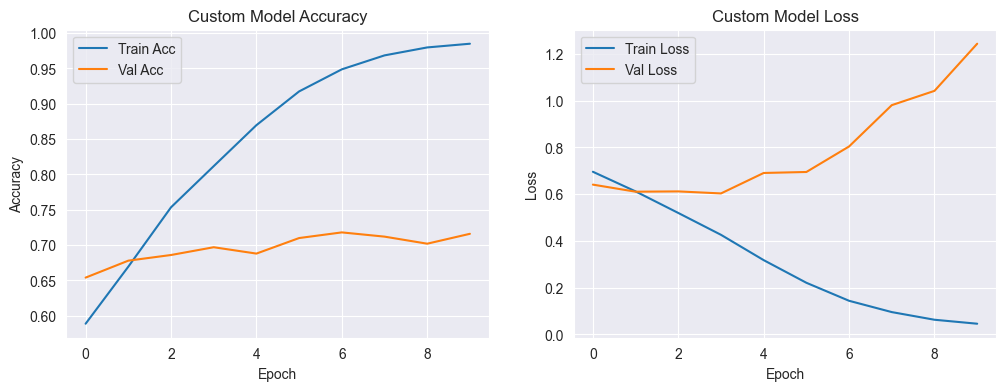

In [5]:
plt.figure(figsize=(12,4))


#Accuracy
plt.subplot(1,2,1)
plt.plot(history_custom.history['accuracy'], label='Train Acc')
plt.plot(history_custom.history['val_accuracy'], label='Val Acc')
plt.title('Custom Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_custom.history['loss'], label='Train Loss')
plt.plot(history_custom.history['val_loss'], label='Val Loss')
plt.title('Custom Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Step 5: Fine Tune VGG16 (Pre-Trained on imagenet
- Load VGG16 without the top classifer layer
- Freeze base model
- Add custom top layers (fine-tune)
- Compile the model
- Callback to save the best model
- Train the model

In [6]:
# Load VGG16 without the top classifier layers

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

#Freeze base model layers to start
base_model.trainable= False

#Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

vgg_model = Model(inputs=base_model.input, outputs=predictions)

#Compile the modelk

vgg_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Callback to save the best model
checkpoint_cb_vgg = tf.keras.callbacks.ModelCheckpoint(
    "models/best_vgg_model.h5", save_best_only=True
)

#Train the model
history_vgg = vgg_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint_cb_vgg]
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.7138 - loss: 0.5255

125/125 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7997 - loss: 0.4065 - val_accuracy: 0.8750 - val_loss: 0.2983
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8646 - loss: 0.3099

125/125 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.8687 - loss: 0.3002 - val_accuracy: 0.8800 - val_loss: 0.2932
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - accuracy: 0.8703 - loss: 0.2803

125/125 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8745 - loss: 0.2819 - val_accuracy: 0.8970 - val_loss: 0.2570
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.8834 - loss: 0.2644

125/125 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8852 - loss: 0.2661 - val_accuracy: 0.9020 - val_loss: 0.2446
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8890 - loss: 0.2594 - val_accuracy: 0.9050 - val_loss: 0.2589
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.8919 - loss: 0.2592

125/125 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.8932 - loss: 0.2523 - val_accuracy: 0.9070 - val_loss: 0.2413
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8945 - loss: 0.2390 - val_accuracy: 0.8980 - val_loss: 0.2450
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8982 - loss: 0.2349 - val_accuracy: 0.9070 - val_loss: 0.2418
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.8938 - loss: 0.2327 - val_accuracy: 0.9030 - val_loss: 0.2573
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9020 - loss: 0.2239 - val_accuracy: 0.9110 - val_loss: 0.2434


# Plot traning vs Validation for VGG16

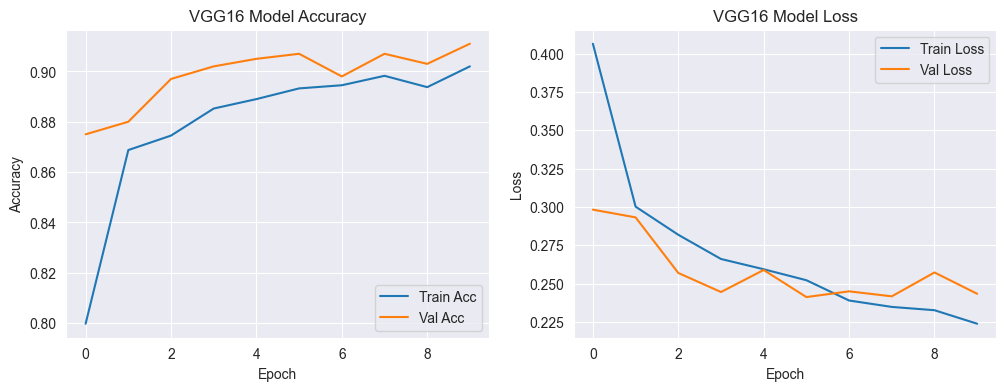

In [7]:
plt.figure(figsize=(12,4))

#Accuracy
plt.subplot(1,2,1)
plt.plot(history_vgg.history['accuracy'], label='Train Acc')
plt.plot(history_vgg.history['val_accuracy'], label='Val Acc')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Loss
plt.subplot(1,2,2)
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Val Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Step 6: Explore the relative performance of the models
- Load the saved models from project

#### Load Best Saved Models

In [8]:
# Load tthe best versions of models

#Load best custom model
best_custom_model = load_model("models/best_model.h5")

#load best VGG16 model
best_vgg_model = load_model("models/best_vgg_model.h5")

#### Prepare Test Data Generator

In [9]:
# Test Data Generatyor

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1, # 1 image at a time
    class_mode="binary",
    shuffle=False # important to match predictions
)


#Get true labels
y_true = test_generator.classes
class_labels =  list(test_generator.class_indices.keys())

Found 2000 images belonging to 2 classes.


#### Evaluate Accuracy
- Evaluates the overall fraction of correct predictions

In [10]:
# Predictions
y_pred_model = (best_custom_model.predict(test_generator) > 0.5).astype("int32")
y_pred_vgg = (best_vgg_model.predict(test_generator) > 0.5).astype("int32")


#Accuracy

acc_model= accuracy_score(y_true, y_pred_model)
acc_vgg = accuracy_score(y_true, y_pred_vgg)

#display custom model and vgg accuracy
print(f"Custom Model Accuracy: {acc_model:.4f}")
print(f"VGG Model Accuracy: {acc_vgg:.4f}")


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 128s 64ms/step
Custom Model Accuracy: 0.7325
VGG Model Accuracy: 0.8855


#### Confusion Metric
- Counts the correct & incorrect class predictions

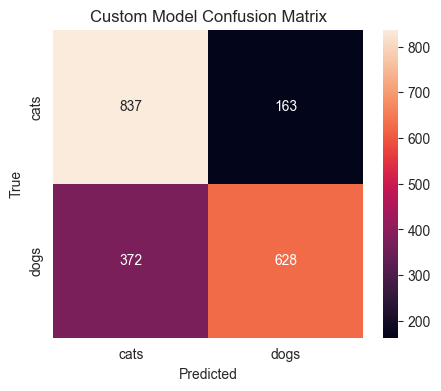

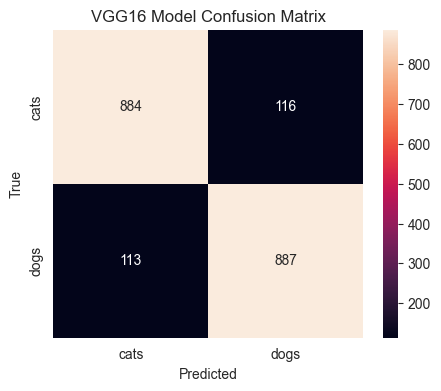

In [11]:
# Custom Model
cm_custom = confusion_matrix(y_true, y_pred_model)
plt.figure(figsize=(5,4))
sns.heatmap(cm_custom, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Custom Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#VGG16 model
cm_vgg = confusion_matrix(y_true, y_pred_vgg)
plt.figure(figsize=(5,4))
sns.heatmap(cm_vgg, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("VGG16 Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Precision, Recall & F1 Score
- Measures correctness, completeness and balance of predictions

In [12]:
#
print("Custom Model Classification Report:")
print(classification_report(y_true, y_pred_model, target_names=class_labels))

print("\n VGG16 Model Classification Report:")
print(classification_report(y_true, y_pred_vgg, target_names=class_labels))


Custom Model Classification Report:
              precision    recall  f1-score   support

        cats       0.69      0.84      0.76      1000
        dogs       0.79      0.63      0.70      1000

    accuracy                           0.73      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.74      0.73      0.73      2000


 VGG16 Model Classification Report:
              precision    recall  f1-score   support

        cats       0.89      0.88      0.89      1000
        dogs       0.88      0.89      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



Precision-Recall Curve
- Visualizes trade off between precision and recall

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step


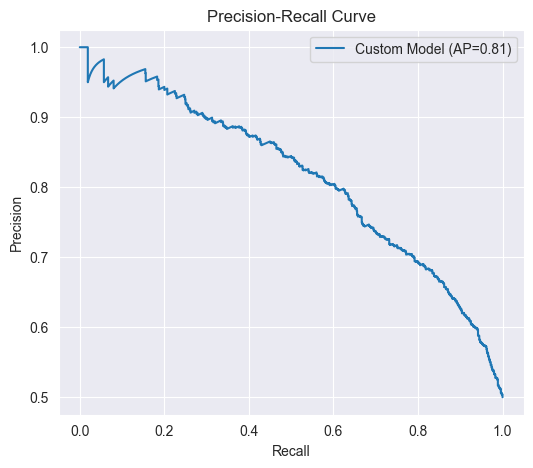

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 125s 62ms/step


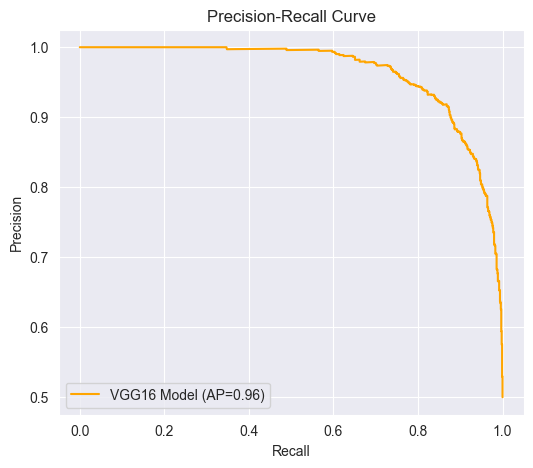

In [13]:
# Custom model probabilities

y_prob_model = best_custom_model.predict(test_generator)
precision_m, recall_m, _ = precision_recall_curve(y_true, y_prob_model)
ap_c = average_precision_score(y_true, y_prob_model)

plt.figure(figsize=(6,5))
plt.plot(recall_m, precision_m, label=f'Custom Model (AP={ap_c:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

#VGG16 Proababilitlies
y_prob_vgg = best_vgg_model.predict(test_generator)
precision_v, recall_v, _ = precision_recall_curve(y_true, y_prob_vgg)
ap_v = average_precision_score(y_true, y_prob_vgg)

plt.figure(figsize=(6,5))
plt.plot(recall_v, precision_v, label=f'VGG16 Model (AP={ap_v:.2f})', color='orange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()




#### Explore Misclassified Examples
- Shows misclassified examples to help understand limitations

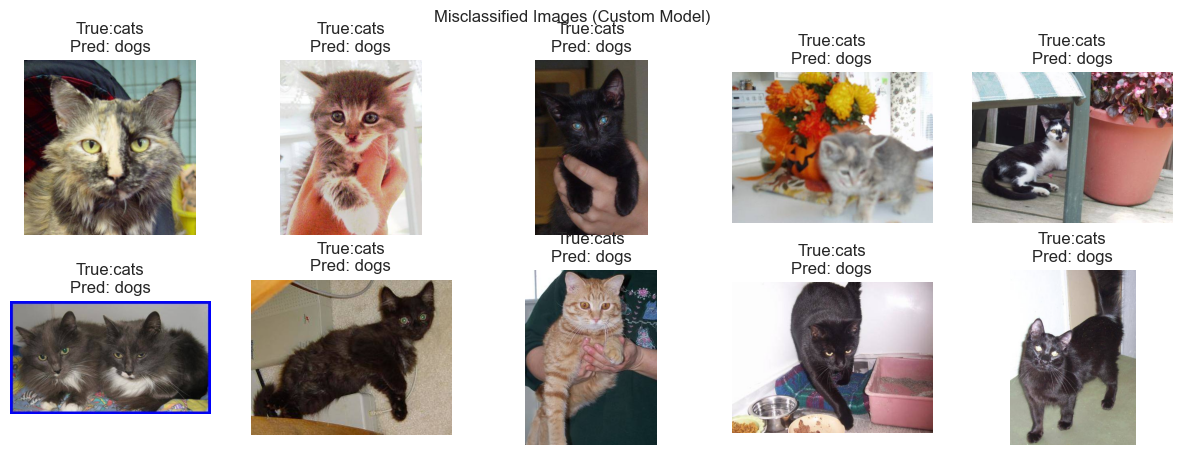

In [14]:
#map Filenames to predictions

y_pred_model_flat = y_pred_model.reshape(-1)
y_true_flat = y_true.reshape(-1)

filenames = test_generator.filenames

#Custom Model misclassifications
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred_model)) if true != pred]

plt.figure(figsize=(15,5))

for i, idx in enumerate(misclassified_indices[:10]):  # show first 10 misclassified
    img_path = Path(test_dir) / filenames[idx]
    img = Image.open(img_path)

    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis('off')
    true_label = class_labels[y_true_flat[idx]]
    pred_label = class_labels[y_pred_model_flat[idx]]

    plt.title(f"True:{true_label}\nPred: {pred_label}")
plt.suptitle("Misclassified Images (Custom Model)")
plt.show()

- Misclassification could be due to background, inverted colouring, position of cat or human presence in photo

#### Final Conclusion:
 - Both the custom CNN and fine-tuned VGG16 accuratley classify cats and dogs. VGG16 seems to overall slightly outperforms the CNN due to the pre trained features
    however by analyzing the graphs and the stats, after a while the custom CNN can get even more accurate than VGG16 by the tenth epoch. Despite this,
    the average metrics over the test set still are in favvor of VGG16. Misclassifgications occur mainly with blurry or partial iamges.
    Overall, the pre-trained model offers better performance and faster convergence overall.
    The custom CNN is still valauble for experimaentation and can get to the level of the pre trained model with time.